In [1]:
# import the stack smol
from datasets import load_dataset

ds_python = load_dataset('bigcode/the-stack-smol', data_dir="data/python", split="train")
ds_java = load_dataset('bigcode/the-stack-smol', data_dir="data/java", split="train")
ds_js = load_dataset('bigcode/the-stack-smol', data_dir="data/javascript", split="train")

Using custom data configuration bigcode--the-stack-smol-7b51f8bde3058781
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--the-stack-smol-95a2b7de57a7cb35
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-95a2b7de57a7cb35/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--the-stack-smol-848a30ee7bac5c92
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-848a30ee7bac5c92/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


run on the-stack-smol but also on the filtered data to make sure stats don't change after filtering, note that we might've missed some comments/docstrings, but this doesn't occur often so if a file has comments in one location that are missed it will probably still not be that relevant

### Python

In [3]:
from text_extraction import get_text

example = """
#general comment
class foo():
    '''
    class docstring
    '''
    
    some_value = 2
    def bar(arg1, arg2):
        ''' function docstring'''
        if arg1 == 2:
            # first comment
            print(arg1)
        else:
            # second comment
            arg2 += 3
        return arg1 + arg2
"""

print(get_text(example))

class docstring
function docstring
general comment first comment second comment


File 4 had {'nl_size': 275, 'nl_ratio': 0.02723851030110935} and seems like a file with comments that should be kept

In [4]:
def extract_nl_text(code):
    text = get_text(code)
    text_list = (text)
    size_list = (len(text))
    ratio_list = (len(text)/len(code))
    print(f"text is:\n {text_list}\n\n and size is {size_list} and ratio is {ratio_list}")
    return {"nl_size": size_list, "nl_ratio": ratio_list}

example = ds_python[9]["content"]
extract_nl_text(example)

text is:
 -*- coding: utf-8 -*-

 and size is 21 and ratio is 0.0055511498810467885


{'nl_size': 21, 'nl_ratio': 0.0055511498810467885}

In [5]:
# define the function to add a comments column to the dataset
COLUMN = "content"

def extract_nl_text(examples):
    text_list = []
    size_list = []
    ratio_list = []
    for code in examples[COLUMN]:
        text = get_text(code)
        text_list.append(text)
        size_list.append(len(text))
        ratio_list.append(len(text)/len(code))
    return {"nl_text": text_list, "nl_size": size_list, "nl_ratio": ratio_list}

In [6]:
ds = ds_python#.select(range(2000))
ds = ds.map(extract_nl_text, batched=True, batch_size=1000)

  0%|          | 0/10 [00:00<?, ?ba/s]

/Users/loubnabenallal/Desktop/HF_internship/bigcode-dataset-0/preprocessing/notebooks/text_extraction.py:86: UserWarning: code couldn't be parsed due to compilation failure, no docstring is extracted
  warnings.warn(
/Users/loubnabenallal/Desktop/HF_internship/bigcode-dataset-0/preprocessing/notebooks/text_extraction.py:95: UserWarning: tokenization error, no comment is extracted
  warnings.warn("tokenization error, no comment is extracted")


In [7]:
import numpy as np
# get mean median and percentiles of nl_size
print(f"Mean comment/code ratio : {np.mean(ds['nl_ratio']):.2f}")
print(f"Median comment/code ratio: {np.median(ds['nl_ratio']):.2f}")
print(f"Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: {np.round(np.percentile(ds['nl_ratio'], [15, 20, 25, 80, 95, 99]), 5)}")
# get percentile corresponding to value 0.01
res01 = ds.filter(lambda x: x['nl_ratio'] < 0.01)
res0 = ds.filter(lambda x: x['nl_ratio'] < 0.000001)
print(f"percentage samples with comment/code ratio < 0.01: {len(res01)*100/len(ds)}")
print(f"percentage samples with comment/code ratio < 0.000001: {len(res0)*100/len(ds)}")

Mean comment/code ratio : 0.18
Median comment/code ratio: 0.11
Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: [0.      0.00993 0.02315 0.31765 0.58318 0.8302 ]


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio < 0.01: 20.03
percentage samples with comment/code ratio < 0.000001: 17.24


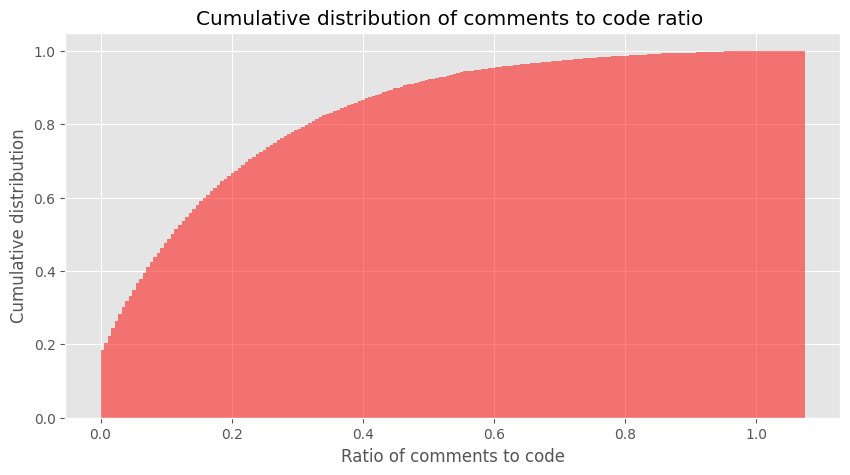

In [14]:
# plot different percentiles from 10 to 99
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(ds["nl_ratio"], bins=200, color="#FF0000", alpha=0.5, density=True, cumulative=True)
#plt.xticks(np.arange(0, 2000, 200))
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Ratio of comments to code")
plt.ylabel("Cumulative distribution")
plt.title("Cumulative distribution of comments to code ratio ")
plt.show()

### files with a very high ratio

In [8]:
print(f"Percentiles of comment/code ratio 80th, 95th and 99th: {np.round(np.percentile(ds['nl_ratio'], [80, 95, 99]), 5)}")

Percentiles of comment/code ratio 80th, 95th and 99th: [0.31765 0.58318 0.8302 ]


In [9]:
res09 = ds.filter(lambda x: x['nl_ratio'] > 0.9)
res08 = ds.filter(lambda x: x['nl_ratio'] > 0.8)
res05 = ds.filter(lambda x: x['nl_ratio'] > 0.75)
print(f"percentage samples with comment/code ratio > 0.9: {len(res09)*100/len(ds)}%")
print(f"percentage samples with comment/code ratio > 0.8: {len(res08)*100/len(ds)}%")
print(f"percentage samples with comment/code ratio > 0.6: {len(res05)*100/len(ds)}%")

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio > 0.9: 0.47%
percentage samples with comment/code ratio > 0.8: 1.29%
percentage samples with comment/code ratio > 0.6: 1.86%


In [179]:
res08.push_to_hub("python_comment_code_ratio_08")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(res05[100]["nl_ratio"])
print(res05[100]["content"])

0.8557635301092572
# Databricks notebook source
# MAGIC %md-sandbox
# MAGIC 
# MAGIC <div style="text-align: center; line-height: 0; padding-top: 9px;">
# MAGIC   <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
# MAGIC </div>

# COMMAND ----------

# MAGIC %md
# MAGIC 
# MAGIC 
# MAGIC # Incremental Data Ingestion with Auto Loader
# MAGIC 
# MAGIC Incremental ETL is important since it allows us to deal solely with new data that has been encountered since the last ingestion. Reliably processing only the new data reduces redundant processing and helps enterprises reliably scale data pipelines.
# MAGIC 
# MAGIC The first step for any successful data lakehouse implementation is ingesting into a Delta Lake table from cloud storage. 
# MAGIC 
# MAGIC Historically, ingesting files from a data lake into a database has been a complicated process.
# MAGIC 
# MAGIC Databricks Auto Loader provides an easy-to-use

### observations:

If we want to filter on code-ratio at least 17% of the files will be removed (ratio is almost 0)
Let's choose a significant threshold at a ratio=0.01, this will remove 20.02% of the files

Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-24428e7ea475b666.arrow


Percentiles after filtering of file size 20th, 80th, 95th and 99th: [  576.    1085.   89521.06]
Percentiles before filtering of file size 20th, 80th, 95th and 99th: [  381.     744.   87595.34]


Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-a115461de9e00a45.arrow


Percentiles of file size in filtered samples 20th, 60th, 80th and 99th: [  263.    1217.4   3054.4  70480.26]


Text(0.5, 1.0, 'File size distribution of filtered samples (ratio=0.01)')

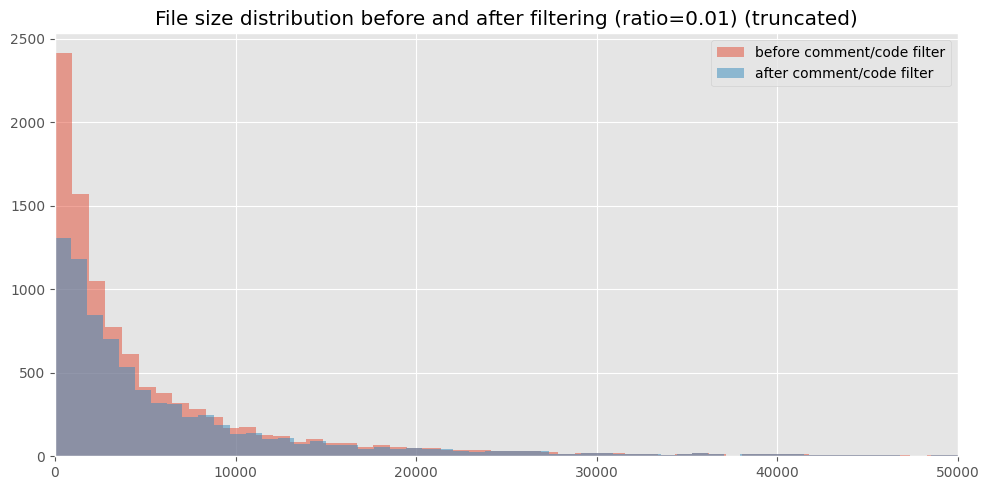

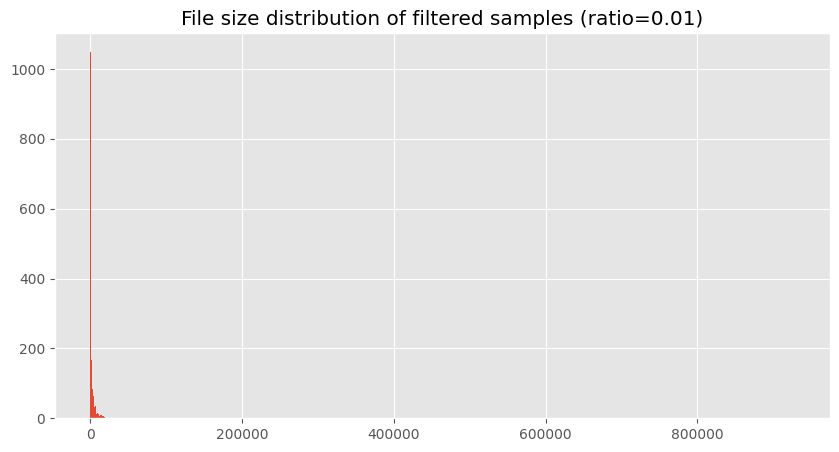

In [81]:
#let's get file size distribution after fiolter on this ratio
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# get file size distribution
file_size = [len(code) for code in ds["content"]]
# get file size distribution after filter on nl_ratio
ds_filter = ds.filter(lambda x: x['nl_ratio'] > 0.01)
file_size_filter = [len(code) for code in ds_filter["content"]]
#print percentiles
print(f"Percentiles after filtering of file size 20th, 80th, 95th and 99th: {np.percentile(file_size_filter, [10, 20, 99])}")
#print percentiles
print(f"Percentiles before filtering of file size 20th, 80th, 95th and 99th: {np.percentile(file_size, [10, 20, 99])}")


# plot overlap between the two plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(file_size, bins=1000, alpha=0.5, label='before comment/code filter')
ax.hist(file_size_filter, bins=1000, alpha=0.5, label='after comment/code filter')
ax.legend(loc='upper right')
# set xlim
ax.set_xlim(0, 50000)
ax.set_title("File size distribution before and after filtering (ratio=0.01) (truncated)")
ax.set_axisbelow(True)
#ax.grid(True, which="major", axis="y")
#ax.grid(True, which="minor", axis="y", linestyle='dashed')
plt.tight_layout()

filtered = ds.filter(lambda x: x['nl_ratio'] < 0.01)
file_size_filtered = [len(code) for code in filtered["content"]]
# print percentiles
print(f"Percentiles of file size in filtered samples 20th, 60th, 80th and 99th: {np.percentile(file_size_filtered, [20, 60, 80, 99])}")
#plot file size distribution
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist([len(code) for code in filtered["content"]], bins=1000)
ax.set_title("File size distribution of filtered samples (ratio=0.01)")

(0.0, 10000.0)

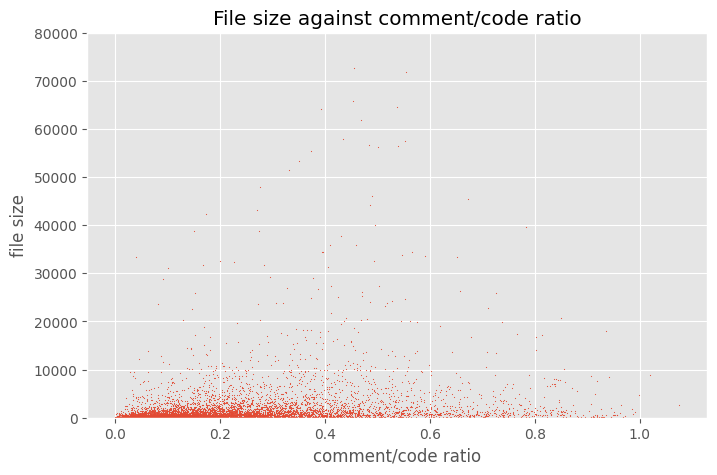

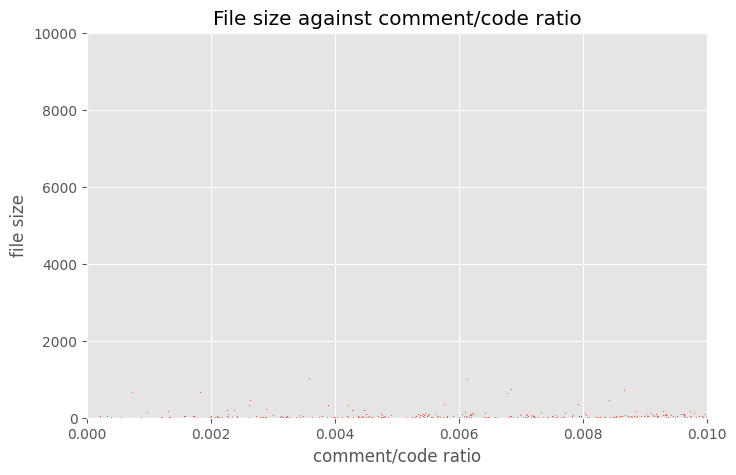

In [91]:
# plot file size as function of  ratio on ds
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
ax.scatter(ds["nl_ratio"], ds["nl_size"], s=0.1)
ax.set_title("File size against comment/code ratio")
ax.set_xlabel("comment/code ratio")
ax.set_ylabel("file size")
# xlim
ax.set_ylim(0, 80_000)


fig, ax = plt.subplots(figsize=(8,5), dpi=100)
ax.scatter(ds["nl_ratio"], ds["nl_size"], s=0.1)
ax.set_title("File size against comment/code ratio")
ax.set_xlabel("comment/code ratio")
ax.set_ylabel("file size")
# xlim
ax.set_xlim(0, 0.01)
ax.set_ylim(0, 10_000)

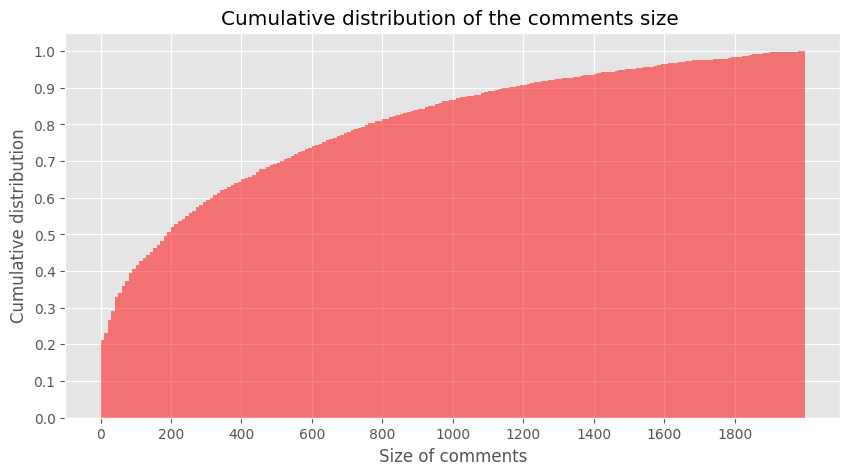

In [56]:
# plot different percentiles from 10 to 99
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(ds["nl_ratio"], bins=200, range=(0, 2000), color="#FF0000", alpha=0.5, density=True, cumulative=True)
plt.xticks(np.arange(0, 2000, 200))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Size of comments")
plt.ylabel("Cumulative distribution")
plt.title("Cumulative distribution of the comments size ")
plt.show()

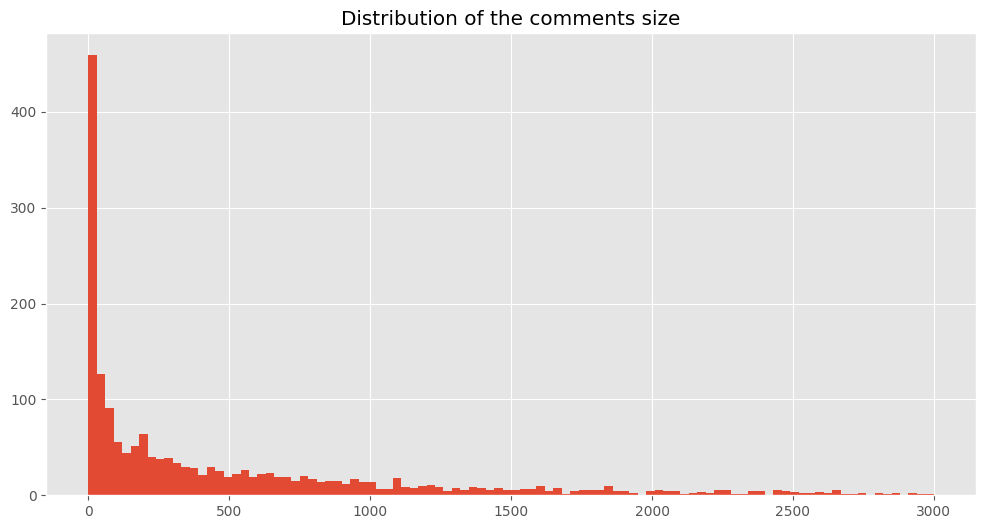

In [68]:
# plot distribution of size of nl_size column
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
# plt hist with xlimit = 20000
plt.hist(ds["nl_size"], bins=100, range=(0, 3000))
plt.title("Distribution of the comments size")
plt.show()

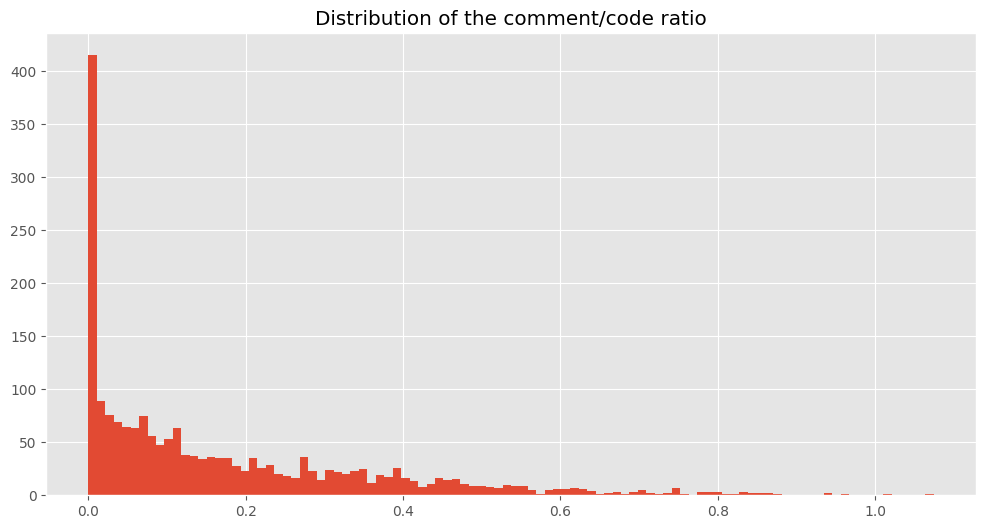

max ratio: 1.0747508305647842


In [81]:
# plot dist of comment to code ratio
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
# plt hist with xlimit = 20000
plt.hist(ds["nl_ratio"], bins=100)
plt.title("Distribution of the comment/code ratio")
plt.show()
print(f"max ratio: {np.max(ds['nl_ratio'])}")

In [92]:
nl_size_total= np.sum(ds["nl_size"])
# number of files with comment size between 0 and 10
ds_no_comment = ds.filter(lambda x: x["nl_ratio"] < 0.01)
print(f"Number of files with almost no comment: {len(ds_no_comment)}, it makes {len(ds_no_comment)*100/len(ds):.2f}% of the dataset")

Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-a115461de9e00a45.arrow


Number of files with almost no comment: 2002, it makes 20.02% of the dataset


Let's analyze some files with almost no comments

In [82]:
ds_no_comment

Dataset({
    features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang', 'nl_text', 'nl_size'],
    num_rows: 363
})

#### Automatic analysis using some heuristics

In [93]:
def is_autogenerated(example, scan_width=5):
    """Check if file is autogenerated by looking for keywords in the first few lines of the file."""
    keywords = ["auto-generated", "autogenerated", "automatically generated"]
    lines = example["content"].splitlines()
    for _, line in zip(range(scan_width), lines):
        for keyword in keywords:
            if keyword in line.lower():
                return {"autogenerated": True}
    else:
        return {"autogenerated": False}

def has_few_assignments(example, minimum=4):
    """Check if file uses symbol '=' less than `minimum` times."""
    lines = example["content"].splitlines()
    counter = 0
    for line in lines:
        counter += line.lower().count("=")
        if counter > minimum:
            return {"has_few_assignments": False}
    return {"has_few_assignments": True}

def has_no_keywords(example):
    """Check if a python file has none of the keywords for: funcion, class, for loop, while loop."""
    keywords = ["def ", "class ", "for ", "while "]
    lines = example["content"].splitlines()
    for line in lines:
        for keyword in keywords:
            if keyword in line.lower():
                return {"has_no_keywords": False}
    return {"has_no_keywords": True}

def apha_stats(example):
    if example["max_line_length"] > 1000 or example["avg_line_length"] > 100 or example["alphanum_fraction"] < 0.25:
        return True
    return False

def is_config_or_test(example, scan_width=5, coeff=0.05):
    """Check if file is a configuration file or a unit test by :
    1- looking for keywords in the first few lines of the file.
    2- counting number of occurence of the words 'config' and 'test' with respect to number of lines.
    """

    keywords = ["unit tests", "test file", "configuration file"]
    lines = example["content"].splitlines()
    count_config = 0
    count_test = 0
    # first test
    for _, line in zip(range(scan_width), lines):
        for keyword in keywords:
            if keyword in line.lower():
                return {"config_or_test": True}
    # second test
    nlines = example["content"].count("\n")
    threshold = int(coeff * nlines)
    for line in lines:
        count_config += line.lower().count("config")
        count_test += line.lower().count("test")
        if count_config > threshold or count_test > threshold:
            return {"config_or_test": True}
    return {"config_or_test": False}

In [95]:
import datasets

datasets.utils.logging.set_verbosity_error()

# count how many files in ds_no_comment are autogenerated
autogenerated = ds_no_comment.map(is_autogenerated)
print(f"Number of files with almost no comment and are *autogenerated*: {len(autogenerated.filter(lambda x: x['autogenerated']))}")

# count how many files in ds_no_comment have few assignments
few_assignments = ds_no_comment.map(has_few_assignments)
number = len(few_assignments.filter(lambda x: x['has_few_assignments']))
print(f"Number of files with almost no comment and have *few assignments*: {number} and represents {number*100/len(ds_no_comment):.2f}% of the no comment dataset")

# count how many files in ds_no_comment have no keywords
no_keywords = ds_no_comment.map(has_no_keywords)
number = len(no_keywords.filter(lambda x: x['has_no_keywords']))
print(f"Number of files with almost no comment and have *no keywords*: {number} and represents {number*100/len(ds_no_comment):.2f}% of the no comment dataset")

config_or_test = ds_no_comment.map(is_config_or_test)
number = len(config_or_test.filter(lambda x: x['config_or_test']))
print(f"Number of files with almost no comment and are *config or test*: {number} and represents {number*100/len(ds_no_comment):.2f}% of the no comment dataset")

#===========Intersection between no keywords/few assignements ============

print("\nIntersection between autogenerated/no keywords/few assignements:")
# files that are both no keywords and few assignements
no_keywords_and_few_assignments = no_keywords.filter(lambda x: x['has_no_keywords']).map(has_few_assignments)
number = len(no_keywords_and_few_assignments.filter(lambda x: x['has_few_assignments']))
print(f"Number of files with almost no comment and have no keywords and few assignments: {number} and represents {number*100/len(ds_no_comment):.2f}% of the no comment dataset")

#===========Intersection with conf and test files ============
# count how many files in ds_no_comment are config or test


print("\nIntersection with config and test files:")
# files that are both no keywords and are config or test
no_keywords_and_config_or_test = no_keywords.filter(lambda x: x['has_no_keywords']).map(is_config_or_test)
number = len(no_keywords_and_config_or_test.filter(lambda x: x['config_or_test']))
print(f"Number of files with almost no comment and have no keywords and are config or test: {number} and represents {number*100/len(ds_no_comment):.2f}% of the no comment dataset")

# files that are both few assignments and are config or test
few_assignments_and_config_or_test = few_assignments.filter(lambda x: x['has_few_assignments']).map(is_config_or_test)
number = len(few_assignments_and_config_or_test.filter(lambda x: x['config_or_test']))
print(f"Number of files with almost no comment and have few assignments and are config or test: {number} and represents {number*100/len(ds_no_comment):.2f}% of the no comment dataset")

Number of files with almost no comment and are *autogenerated*: 2
Number of files with almost no comment and have *few assignments*: 639 and represents 31.92% of the no comment dataset
Number of files with almost no comment and have *no keywords*: 450 and represents 22.48% of the no comment dataset
Number of files with almost no comment and are *config or test*: 490 and represents 24.48% of the no comment dataset

Intersection between autogenerated/no keywords/few assignements:
Number of files with almost no comment and have no keywords and few assignments: 298 and represents 14.89% of the no comment dataset

Intersection with config and test files:
Number of files with almost no comment and have no keywords and are config or test: 57 and represents 2.85% of the no comment dataset
Number of files with almost no comment and have few assignments and are config or test: 130 and represents 6.49% of the no comment dataset


In [97]:
# run statistics above on the original ds
autogenerated = ds.map(is_autogenerated)
few_assignments = ds.map(has_few_assignments)
no_keywords = ds.map(has_no_keywords)
no_keywords_and_few_assignments = no_keywords.filter(lambda x: x['has_no_keywords']).map(has_few_assignments)

# count how many files in ds are autogenerated
print(f"Number of files with are autogenerated: {len(autogenerated.filter(lambda x: x['autogenerated']))}")

# count how many files in ds have few assignments
number = len(few_assignments.filter(lambda x: x['has_few_assignments']))
print(f"Number of files with have few assignments: {number} and represents {number*100/len(ds):.2f}% of the dataset")

# count how many files in ds have no keywords
number = len(no_keywords.filter(lambda x: x['has_no_keywords']))
print(f"Number of files with have no keywords: {number} and represents {number*100/len(ds):.2f}% of the dataset")

# files that are both no keywords and few assignements
number = len(no_keywords_and_few_assignments.filter(lambda x: x['has_few_assignments']))
print(f"Number of files with have no keywords and few assignments: {number} and represents {number*100/len(ds):.2f}% of the dataset")

Number of files with are autogenerated: 50
Number of files with have few assignments: 1645 and represents 16.45% of the dataset
Number of files with have no keywords: 924 and represents 9.24% of the dataset
Number of files with have no keywords and few assignments: 539 and represents 5.39% of the dataset


### Java

In [15]:
import pygments
from pygments.lexers import get_lexer_by_name

def comment_size(text, language="java"):
    """
    Calculuate the ratio of comments to code in a JavaScript program.
    """
    lexer = get_lexer_by_name(language)
    tokens = pygments.lex(text, lexer)
    comment_len = 0
    for token_type, token in tokens:
        if token_type == pygments.token.Comment.Multiline or token_type == pygments.token.Comment.Single:
            comment_len += len(token) # token is a string with the comment contents
    return comment_len

COLUMN = "content"

def extract_nl_text_j(examples, language="java"):
    size_list = []
    ratio_list = []
    for code in examples[COLUMN]:
        size = comment_size(code, language=language)
        size_list.append(size)
        ratio_list.append(size/len(code))
    return {"nl_size": size_list, "nl_ratio": ratio_list}

In [16]:
example = """
#general comment
class foo():
    '''
    class docstring
    '''
    
    some_value = 2
    def bar(arg1, arg2):
        ''' function docstring'''
        if arg1 == 2:
            # first comment
            print(arg1)
        else:
            # second comment
            arg2 += 3
        return arg1 + arg2
"""

comment_size(example, language="python")

47

In [17]:
# define the function to add a comments column to the dataset
COLUMN = "content"

def extract_nl_text_j(examples, language="java"):
    size_list = []
    ratio_list = []
    for code in examples[COLUMN]:
        size = comment_size(code, language=language)
        size_list.append(size)
        ratio_list.append(size/len(code))
    return {"nl_size": size_list, "nl_ratio": ratio_list}

In [18]:
import numpy as np

ds = ds_java#.select(range(2000))
ds = ds.map(extract_nl_text_j, batched=True, batch_size=1000)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [7]:
ratio = np.sum(ds["nl_ratio"])*100 / np.sum([len(code) for code in ds["content"]])
print(f"Comment to code ratio of the dataset: {ratio:.2f}%")

# get mean median and percentiles of nl_size
print(f"Mean comment ratio: {np.mean(ds['nl_ratio']):.2f}")
print(f"Median comment ratio: {np.median(ds['nl_ratio']):.2f}")
print(f"Percentiles of comments ratio 20th, 22nd, 25th, 80th, 95th and 99th: {np.percentile(ds['nl_ratio'], [20,  22, 25, 80, 95, 99])}")

Comment to code ratio of the dataset: 0.00%
Mean comment ratio: 0.23
Median comment ratio: 0.16
Percentiles of comments ratio 20th, 22nd, 25th, 80th, 95th and 99th: [0.00161892 0.01337841 0.02529046 0.42964824 0.71106073 0.88636626]


In [19]:
ds_no_comment = ds.filter(lambda x: x["nl_ratio"] < 0.01)
print(f"percentage samples with comment/code ratio < 0.01: {len(ds_no_comment)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio < 0.01: 21.3


### Long files

In [181]:
res09 = ds.filter(lambda x: x['nl_ratio'] > 0.9)
res08 = ds.filter(lambda x: x['nl_ratio'] > 0.8)
res05 = ds.filter(lambda x: x['nl_ratio'] > 0.75)
print(f"percentage samples with comment/code ratio > 0.9: {len(res09)*100/len(ds)}%")
print(f"percentage samples with comment/code ratio > 0.8: {len(res08)*100/len(ds)}%")
print(f"percentage samples with comment/code ratio > 0.6: {len(res05)*100/len(ds)}%")

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio > 0.9: 0.85%
percentage samples with comment/code ratio > 0.8: 2.55%
percentage samples with comment/code ratio > 0.6: 3.87%


  0%|          | 0/10 [00:00<?, ?ba/s]

Percentiles after filtering of file size 20th, 80th, 95th and 99th: [  720.    1139.   67461.11]
Percentiles before filtering of file size 20th, 80th, 95th and 99th: [  468.9    856.   62644.21]
Percentiles of file size in filtered samples 20th, 60th, 80th and 99th: [  376.8   1318.2   2755.2  26276.59]


Text(0.5, 1.0, 'File size distribution of filtered samples (ratio=0.01)')

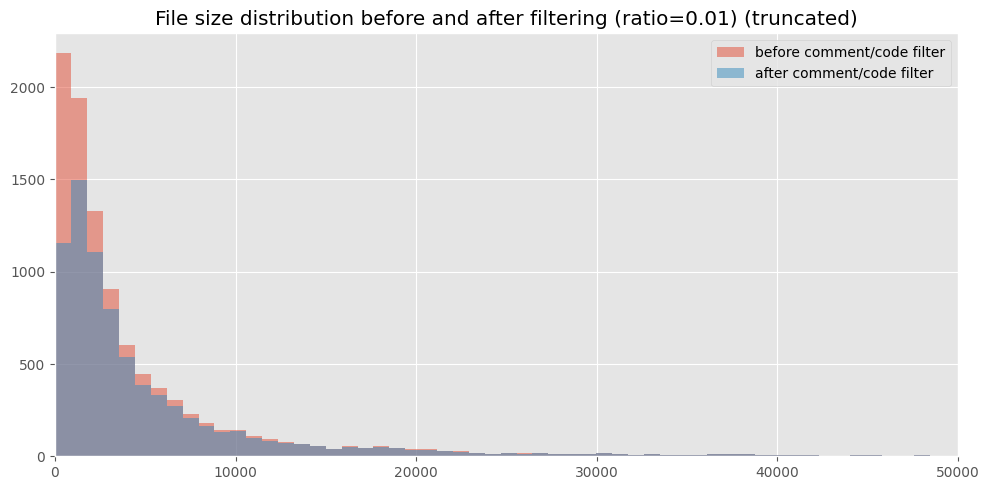

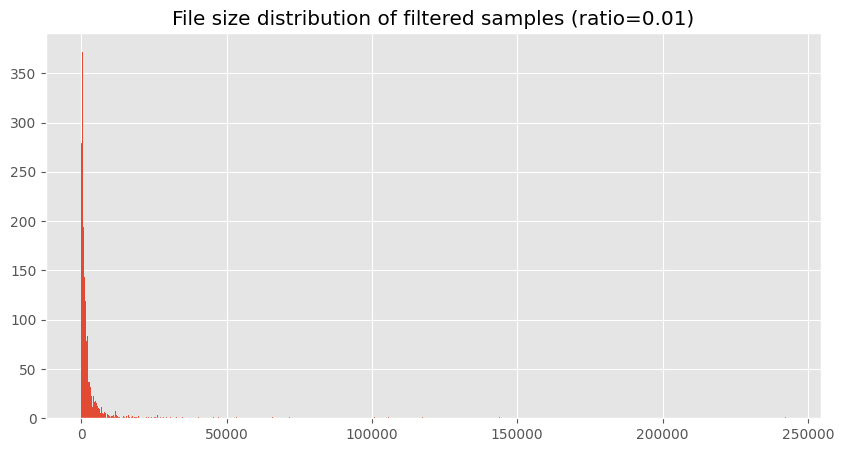

In [108]:
#let's get file size distribution after fiolter on this ratio
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# get file size distribution
file_size = [len(code) for code in ds["content"]]
# get file size distribution after filter on nl_ratio
ds_filter = ds.filter(lambda x: x['nl_ratio'] > 0.01)
file_size_filter = [len(code) for code in ds_filter["content"]]
#print percentiles
print(f"Percentiles after filtering of file size 20th, 80th, 95th and 99th: {np.percentile(file_size_filter, [10, 20, 99])}")
#print percentiles
print(f"Percentiles before filtering of file size 20th, 80th, 95th and 99th: {np.percentile(file_size, [10, 20, 99])}")


# plot overlap between the two plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(file_size, bins=1000, alpha=0.5, label='before comment/code filter')
ax.hist(file_size_filter, bins=1000, alpha=0.5, label='after comment/code filter')
ax.legend(loc='upper right')
# set xlim
ax.set_xlim(0, 50000)
ax.set_title("File size distribution before and after filtering (ratio=0.01) (truncated)")
ax.set_axisbelow(True)
#ax.grid(True, which="major", axis="y")
#ax.grid(True, which="minor", axis="y", linestyle='dashed')
plt.tight_layout()

filtered = ds.filter(lambda x: x['nl_ratio'] < 0.01)
file_size_filtered = [len(code) for code in filtered["content"]]
# print percentiles
print(f"Percentiles of file size in filtered samples 20th, 60th, 80th and 99th: {np.percentile(file_size_filtered, [20, 60, 80, 99])}")
#plot file size distribution
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist([len(code) for code in filtered["content"]], bins=1000)
ax.set_title("File size distribution of filtered samples (ratio=0.01)")

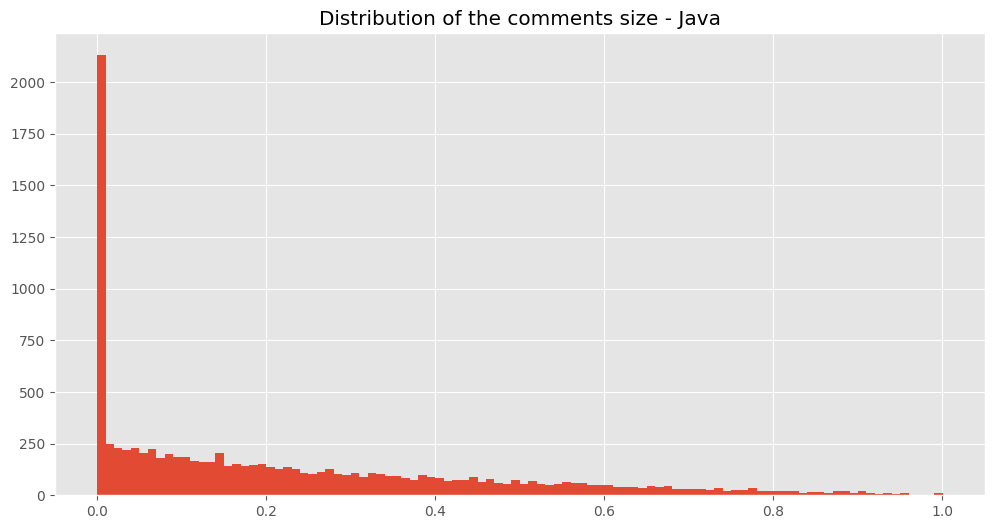

In [109]:
# plot distribution of size of nl_size column
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
# plt hist with xlimit = 20000
plt.hist(ds["nl_ratio"], bins=100)
plt.title("Distribution of the comments size - Java")
plt.show()

In [110]:
nl_size_total= np.sum(ds["nl_size"])
# number of files with comment size between 0 and 10
ds_no_comment = ds.filter(lambda x: x["nl_ratio"] <0.00001)
print(f"Number of files with almost no comment: {len(ds_no_comment)}, it makes {len(ds_no_comment)*100/len(ds):.2f}% of the dataset")

  0%|          | 0/10 [00:00<?, ?ba/s]

Number of files with almost no comment: 1990, it makes 19.90% of the dataset


We will remove at least 19% le'ts choose 0?.01 and remove 21.3%

### Javascript

In [182]:
import numpy as np
from functools import partial

    
ds =ds_js#.select(range(2000))
ds = ds.map(partial(extract_nl_text_j, language="javascript"), batched=True, batch_size=1000)

In [114]:
ratio = np.sum(ds["nl_ratio"])*100 / np.sum([len(code) for code in ds["content"]])
print(f"Comment to code ratio of the dataset: {ratio:.2f}%")

# get mean median and percentiles of nl_size
print(f"Mean comment ratio: {np.mean(ds['nl_ratio']):.2f}")
print(f"Median comment ratio: {np.median(ds['nl_ratio']):.2f}")
#print per
print(f"Percentiles of comments ratio 20th, 22nd, 25th, 80th, 95th and 99th: {np.percentile(ds['nl_ratio'], [20,  40, 80, 95, 99])}")

Comment to code ratio of the dataset: 0.00%
Mean comment ratio: 0.12
Median comment ratio: 0.02
Percentiles of comments ratio 20th, 22nd, 25th, 80th, 95th and 99th: [0.         0.         0.2140928  0.57098165 0.83334366]


In [116]:
ds_no_comment = ds.filter(lambda x: x["nl_ratio"] <=0)
print(f"percentage samples with comment/code ratio < 0.01: {len(ds_no_comment)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio < 0.01: 40.97


### Long files

In [183]:
res09 = ds.filter(lambda x: x['nl_ratio'] > 0.9)
res08 = ds.filter(lambda x: x['nl_ratio'] > 0.8)
res05 = ds.filter(lambda x: x['nl_ratio'] > 0.75)
print(f"percentage samples with comment/code ratio > 0.9: {len(res09)*100/len(ds)}%")
print(f"percentage samples with comment/code ratio > 0.8: {len(res08)*100/len(ds)}%")
print(f"percentage samples with comment/code ratio > 0.6: {len(res05)*100/len(ds)}%")

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio > 0.9: 0.58%
percentage samples with comment/code ratio > 0.8: 1.18%
percentage samples with comment/code ratio > 0.6: 1.77%


For Javascipt, we will remove at least 40% of the files (they have 0 comments)

Percentiles after filtering of file size 20th, 50th, 80th,  and 99th: [   789.     2360.5    8118.   233734.75]
Percentiles before filtering of file size 20th, 50th, 80th,  and 99th (print as int): [   481   1604   6277 282832]
Percentiles of file size in filtered samples 20th, 50th, 80th and 99th: [   301    965   3839 317238]


Text(0.5, 1.0, 'File size distribution of filtered samples (ratio=0.01)')

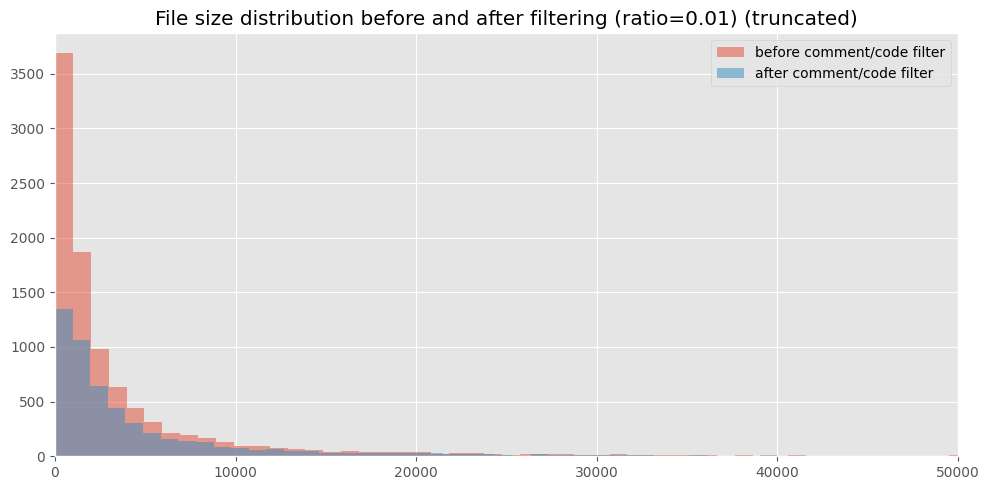

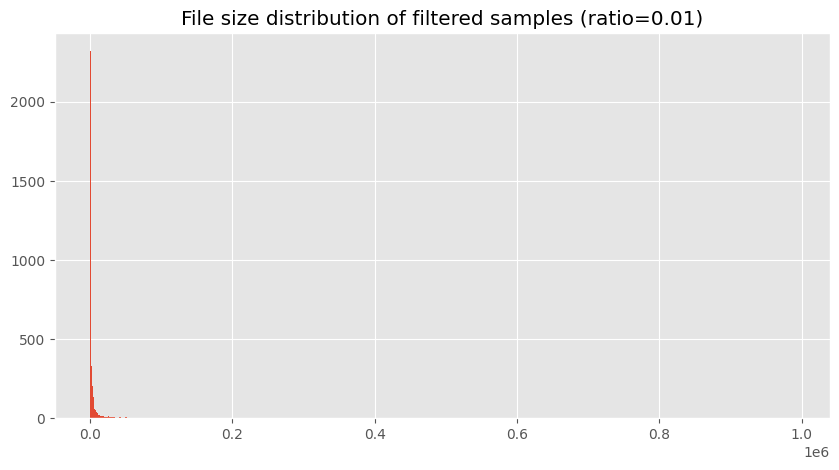

In [122]:
#let's get file size distribution after fiolter on this ratio
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# get file size distribution
file_size = [len(code) for code in ds["content"]]
# get file size distribution after filter on nl_ratio
ds_filter = ds.filter(lambda x: x['nl_ratio'] > 0.01)
file_size_filter = [len(code) for code in ds_filter["content"]]
#print percentiles
print(f"Percentiles after filtering of file size 20th, 50th, 80th,  and 99th: {np.percentile(file_size_filter, [20, 50, 80, 99])}")
#print percentiles
print(f"Percentiles before filtering of file size 20th, 50th, 80th,  and 99th (print as int): {np.percentile(file_size, [20, 50, 80, 99]).astype(int)}")


# plot overlap between the two plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(file_size, bins=1000, alpha=0.5, label='before comment/code filter')
ax.hist(file_size_filter, bins=1000, alpha=0.5, label='after comment/code filter')
ax.legend(loc='upper right')
# set xlim
ax.set_xlim(0, 50000)
ax.set_title("File size distribution before and after filtering (ratio=0.01) (truncated)")
ax.set_axisbelow(True)
#ax.grid(True, which="major", axis="y")
#ax.grid(True, which="minor", axis="y", linestyle='dashed')
plt.tight_layout()

filtered = ds.filter(lambda x: x['nl_ratio'] < 0.01)
file_size_filtered = [len(code) for code in filtered["content"]]
# print percentiles
print(f"Percentiles of file size in filtered samples 20th, 50th, 80th and 99th: {np.percentile(file_size_filtered, [20, 50, 80, 99]).astype(int)}")
#plot file size distribution
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist([len(code) for code in filtered["content"]], bins=1000)
ax.set_title("File size distribution of filtered samples (ratio=0.01)")

In [132]:
# subset of the filtered dataset and without pii

from datasets import load_dataset, Dataset
import pandas as pd
import os

# 1% subset of BigCode corpus with safe licenses, each languages has 10k samples
seed = 0
size = 10_000

language= "python"

thestack = load_dataset('bigcode/the-stack-pjjs-no-pii-filtered', use_auth_token=True, split="train", streaming=True, data_dir=f"data/{language}/")
print(f"subset {language} loaded")
ds = thestack.shuffle(seed=seed)

# 10k subset of random samples from ds
small_ds = list(ds.take(size))
# convert to Datasets
small_ds = Dataset.from_pandas(pd.DataFrame(data=small_ds))
small_ds.to_json("data.json")

subset javascript loaded


In [133]:
small_ds.save_to_disk(f"data/{language}/the-stack-pjjs-no-pii-filtered-10k")

#### Python

In [126]:
# define the function to add a comments column to the dataset
COLUMN = "content"

def extract_nl_text(examples):
    text_list = []
    size_list = []
    ratio_list = []
    for code in examples[COLUMN]:
        text = get_text(code)
        text_list.append(text)
        size_list.append(len(text))
        ratio_list.append(len(text)/len(code))
    return {"nl_text": text_list, "nl_size": size_list, "nl_ratio": ratio_list}
    
ds = small_ds#.select(range(2000))
ds = ds.map(extract_nl_text, batched=True, batch_size=1000)

  0%|          | 0/10 [00:00<?, ?ba/s]

Comment to code ratio of the dataset: 15.86%
Mean comment/code ratio : 0.15
Median comment/code ratio: 0.09
Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: [0.      0.      0.00996 0.27841 0.52219 0.8123 ]


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio < 0.01: 25.01
percentage samples with comment/code ratio < 0.000001: 22.32


In [ ]:
import numpy as np

ratio = np.sum(ds["nl_size"])*100 / np.sum([len(code) for code in ds["content"]])
print(f"Comment to code ratio of the dataset: {ratio:.2f}%")

# get mean median and percentiles of nl_size
print(f"Mean comment/code ratio : {np.mean(ds['nl_ratio']):.2f}")
print(f"Median comment/code ratio: {np.median(ds['nl_ratio']):.2f}")
print(f"Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: {np.round(np.percentile(ds['nl_ratio'], [15, 20, 25, 80, 95, 99]), 5)}")
# get percentile corresponding to value 0.01
res01 = ds.filter(lambda x: x['nl_ratio'] < 0.01)
res0 = ds.filter(lambda x: x['nl_ratio'] < 0.000001)
print(f"percentage samples with comment/code ratio < 0.01: {len(res01)*100/len(ds)}")
print(f"percentage samples with comment/code ratio < 0.000001: {len(res0)*100/len(ds)}")

### Java

In [129]:
import numpy as np

ds = small_ds#.select(range(2000))
ds = ds.map(extract_nl_text_j, batched=True, batch_size=1000)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [130]:
ratio = np.sum(ds["nl_size"])*100 / np.sum([len(code) for code in ds["content"]])
print(f"Comment to code ratio of the dataset: {ratio:.2f}%")

# get mean median and percentiles of nl_size
print(f"Mean comment/code ratio : {np.mean(ds['nl_ratio']):.2f}")
print(f"Median comment/code ratio: {np.median(ds['nl_ratio']):.2f}")
print(f"Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: {np.round(np.percentile(ds['nl_ratio'], [15, 20, 25, 80, 95, 99]), 5)}")
# get percentile corresponding to value 0.01
res01 = ds.filter(lambda x: x['nl_ratio'] < 0.01)
res0 = ds.filter(lambda x: x['nl_ratio'] < 0.000001)
print(f"percentage samples with comment/code ratio < 0.01: {len(res01)*100/len(ds)}")
print(f"percentage samples with comment/code ratio < 0.000001: {len(res0)*100/len(ds)}")

Comment to code ratio of the dataset: 19.57%
Mean comment/code ratio : 0.19
Median comment/code ratio: 0.11
Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: [0.      0.      0.      0.36918 0.67769 0.8619 ]


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio < 0.01: 27.57
percentage samples with comment/code ratio < 0.000001: 25.81


  0%|          | 0/10 [00:00<?, ?ba/s]

Percentiles after filtering of file size 20th, 50th, 80th,  and 99th: [  953.8   2296.    6114.   44941.88]
Percentiles before filtering of file size 20th, 50th, 80th,  and 99th (print as int): [  663  1829  5041 40225]


  0%|          | 0/10 [00:00<?, ?ba/s]

Percentiles of file size in filtered samples 20th, 50th, 80th and 99th: [  328   882  2552 21046]


Text(0.5, 1.0, 'File size distribution of filtered samples (ratio=0.01)')

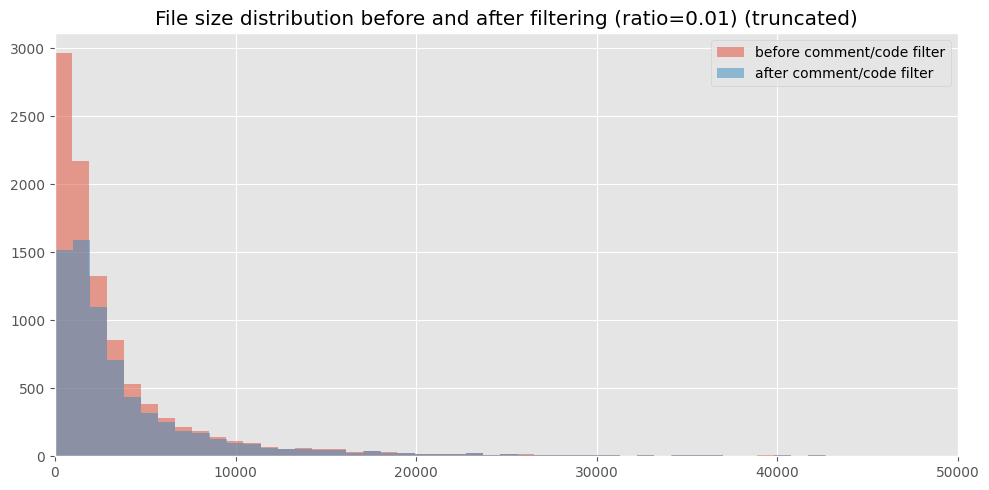

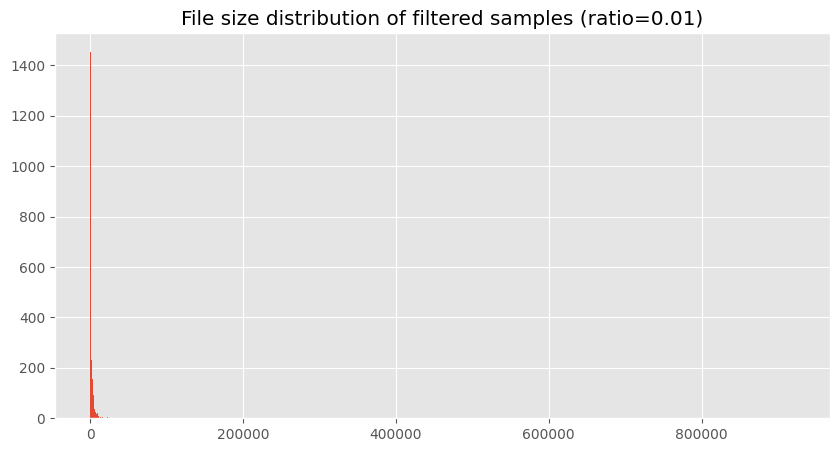

In [131]:
#let's get file size distribution after fiolter on this ratio
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# get file size distribution
file_size = [len(code) for code in ds["content"]]
# get file size distribution after filter on nl_ratio
ds_filter = ds.filter(lambda x: x['nl_ratio'] > 0.01)
file_size_filter = [len(code) for code in ds_filter["content"]]
#print percentiles
print(f"Percentiles after filtering of file size 20th, 50th, 80th,  and 99th: {np.percentile(file_size_filter, [20, 50, 80, 99])}")
#print percentiles
print(f"Percentiles before filtering of file size 20th, 50th, 80th,  and 99th (print as int): {np.percentile(file_size, [20, 50, 80, 99]).astype(int)}")


# plot overlap between the two plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(file_size, bins=1000, alpha=0.5, label='before comment/code filter')
ax.hist(file_size_filter, bins=1000, alpha=0.5, label='after comment/code filter')
ax.legend(loc='upper right')
# set xlim
ax.set_xlim(0, 50000)
ax.set_title("File size distribution before and after filtering (ratio=0.01) (truncated)")
ax.set_axisbelow(True)
#ax.grid(True, which="major", axis="y")
#ax.grid(True, which="minor", axis="y", linestyle='dashed')
plt.tight_layout()

filtered = ds.filter(lambda x: x['nl_ratio'] < 0.01)
file_size_filtered = [len(code) for code in filtered["content"]]
# print percentiles
print(f"Percentiles of file size in filtered samples 20th, 50th, 80th and 99th: {np.percentile(file_size_filtered, [20, 50, 80, 99]).astype(int)}")
#plot file size distribution
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist([len(code) for code in filtered["content"]], bins=1000)
ax.set_title("File size distribution of filtered samples (ratio=0.01)")

## Javascript

In [192]:
import numpy as np
from functools import partial

    
ds =ds_js#.select(range(2000))
ds = ds.map(partial(extract_nl_text_j, language="javascript"), batched=True, batch_size=1000)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [135]:
ratio = np.sum(ds["nl_size"])*100 / np.sum([len(code) for code in ds["content"]])
print(f"Comment to code ratio of the dataset: {ratio:.2f}%")

# get mean median and percentiles of nl_size
print(f"Mean comment/code ratio : {np.mean(ds['nl_ratio']):.2f}")
print(f"Median comment/code ratio: {np.median(ds['nl_ratio']):.2f}")
print(f"Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: {np.round(np.percentile(ds['nl_ratio'], [15, 20, 25, 80, 95, 99]), 5)}")
# get percentile corresponding to value 0.01
res01 = ds.filter(lambda x: x['nl_ratio'] < 0.01)
res0 = ds.filter(lambda x: x['nl_ratio'] < 0.000001)
print(f"percentage samples with comment/code ratio < 0.01: {len(res01)*100/len(ds)}")
print(f"percentage samples with comment/code ratio < 0.000001: {len(res0)*100/len(ds)}")

Comment to code ratio of the dataset: 12.40%
Mean comment/code ratio : 0.12
Median comment/code ratio: 0.02
Percentiles of comment/code ratio 15th, 20th, 25, 80th, 95th and 99th: [0.      0.      0.      0.21409 0.57098 0.83334]


  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with comment/code ratio < 0.01: 45.44
percentage samples with comment/code ratio < 0.000001: 40.97


Numbers are consistent even after line length filtering

### Conclusion

* filtering files with a low comment to code ratio:
    * 0.01 seems a good min threshold for all languages, it removes:
        * 20% of Python files (17% of files have 0 commenst anyway)
        * 21% of Java files (19% of files have 0 comments)
        * 40% of JS files (40% of files have 0 comments)
        * the volume of data removed will probably be less than %files since many short files are removed

* filtering files with a high comment to code ratio:
    * 0.8 seems a good max threshold for all languages, it removes:
        * 1.3% of Python files
        * 2% of Java files
        * 1.13% of JS files
        * the files are usually shorts and mostly text about implementations or just conmmented config code like in this dataset that you can preview

These stats are on the-stack-smol, I ran them on the filtered data we're training on and they didn't change much